### Distribution Analysis at a Cluster X MSA level
#### Sarthak Arora

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math as mt
from unidip import UniDip
import unidip.dip as dip
from scipy import stats
import statsmodels.api as sm
import pylab
from scipy.stats import norm
from Common_Functions import add_unique_identifier, data_split
from statsmodels.stats.multitest import fdrcorrection


import warnings
warnings.filterwarnings('ignore')

In [3]:
os.getcwd()

'/home/lennon_mccartney/Downloads/Prediction-of-commercial-insurance-payments-for-surgical-procedure-using-DataRobot-main'

### getting cluster groups we get using only the surgical cost 

In [11]:
df_clusters = pd.read_csv("Kmeans_clusters/clusters_only_using_NormCost.csv")
cluster_0 = df_clusters[df_clusters["cluster"] == 0].group.values
cluster_1 = df_clusters[df_clusters["cluster"] == 1].group.values
cluster_2 = df_clusters[df_clusters["cluster"] == 2].group.values

In [12]:
# cluster_0 = ["ant_tls_fusion",
# "colorect",
# "femoral shaft fixation",
# "hepat",
# "hip_fracture_fixation",
# "intracranial_thromb",
# "post_cerv_fusion",
# "post_tls_fusion",
# "prox_tibia_fixation",
# "revision_tha",
# "revision_tka",
# "tha",
# "thoracic",
# "tka",
# "tpa"]

# cluster_1 = ["breast reconstruction",
# "bsp",
# "bunionectomy",
# "cardiac ablation_additional_discrete",
# "cardiac ablation_linear_focal",
# "cardiac_ablaton_anesthesia",
# "cardiac_ablaton_ice",
# "clavicle fixation",
# "fess",
# "hysterect",
# "kidney ablation",
# "lap appendectomy",
# "mastectomy",
# "navigation",
# "orthovisc_monovisc",
# "pnn",
# "robotic_assisted_surgery",
# "rtc_slap_bank",
# "septoplasty",
# "tavr"]

# cluster_2 = [
#     "ankle_fix",
# "ant_cerv_fusion",
# "bariatric",
# "cardiac ablation",
# "hernia",
# "laac",
# "liver ablation",
# "lung ablation",
# "lung ablation",
# "partial shoulder arthroplasty",
# "pka",
# "prostatectomy",
# "proximal humerus",
# "radius/ulna internal fixation",
# "tsa"
# ]

### reading the main data and applying preprocessing functions

In [10]:
data = pd.read_csv('Data_Files/JnJ_Files/priv_mcare_f_pay_2022Oct18.csv')
data = add_unique_identifier(data)
model_data, future_data = data_split(data, count_col_name = 'priv_count')
data = model_data

In [13]:
## number of unique procedures in the training data
data["group"].nunique()

42

In [14]:
## total number of missing mcare_median values in the training data
total_mcare_missing = data["mcare_pay_median"].isna().sum()
total_mcare_missing

470

### adding a new column to the training data for cluster labels

In [15]:
cluster_labels = []
for i in range(len(data)):
    if data["group"].iloc[i] in cluster_0:
        cluster_labels.append(0)
    elif  data["group"].iloc[i] in cluster_1:
        cluster_labels.append(1)
    elif  data["group"].iloc[i] in cluster_2:
        cluster_labels.append(2)
    else:
        cluster_labels.append("NaN")

In [16]:
data["clusters"] = cluster_labels

In [17]:
cluster_means = data.groupby('clusters', as_index=False)['mcare_pay_median'].mean().rename(columns={'mcare_pay_median':'mcare_cluster_mean'})

[Text(0.5, 0, 'Cluster_Label'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Split of Data Over Clusters')]

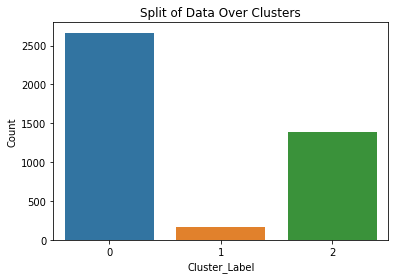

In [18]:
fig = sns.barplot(data=data.groupby(by = ["clusters"]).size().reset_index(),x="clusters",y = 0)
fig.set(xlabel ="Cluster_Label", ylabel = "Count", title ='Split of Data Over Clusters')

### creating a dataframe having number of training examples at an MSA X Cluster Label level. 

In [19]:
da_points = data.groupby(by = ['clusters','msa']).size().reset_index()

### Looking at how the number of missing Mcare median values change as we change the threshold (i.e. the minimum number of points we require in a MSA X Cluster distribution)

[Text(0.5, 0, 'Threshold'),
 Text(0, 0.5, '%age of Missing Medicare Median'),
 Text(0.5, 1.0, 'Threshold v/s Missing Mcare')]

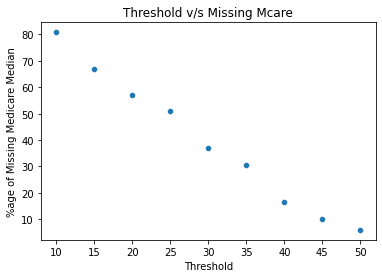

In [20]:
thresholds = [10,15,20,25,30,35,40,45,50]
missing_count = []
for t in thresholds:
    temp1 = da_points[da_points[0] >= t]
    temp2 = data.merge(temp1, on = ['clusters','msa'],how = 'inner')
    missing_count.append(temp2["mcare_pay_median"].isna().sum())
fig = sns.scatterplot(x=thresholds,y = 100*(missing_count/total_mcare_missing))
fig.set(xlabel ="Threshold", ylabel = "%age of Missing Medicare Median", title ='Threshold v/s Missing Mcare')

In [21]:
da_points = da_points[da_points[0] >= 15]

[Text(0.5, 0, 'Cluster_Label'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Split of Data Over Clusters (after thresholding)')]

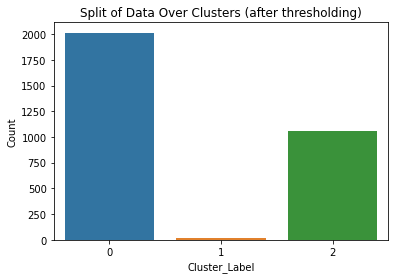

In [22]:
fig = sns.barplot(data=da_points.groupby(by = ["clusters"]).sum().reset_index(),x="clusters",y = 0)
fig.set(xlabel ="Cluster_Label", ylabel = "Count", title ='Split of Data Over Clusters (after thresholding)')

### filtering out the MSA X Cluster sets which have more than or equal to 15 training examples

In [23]:
filter_df = data.merge(da_points, on = ['clusters','msa'],how = 'inner')
filter_df = filter_df.merge(cluster_means, on = ['clusters'], how = 'left')
filter_df["msa_cluster"] = filter_df["clusters"].astype(str) + "_" + filter_df["msa"].astype(str)
filter_df

,id,msa,year,site,group,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_count,...,mcare_pay_median,mcare_pay_sd,CBSA_NAME,State,lon,lat,clusters,0,mcare_cluster_mean,msa_cluster
0,26420.0_2018_Inpatient_breast reconstruction,26420.0,2018,Inpatient,breast reconstruction,51.0,47327.576470,21408.000,23351.715,81.0,...,10395.16,12242.654150,"Houston-The Woodlands-Sugar Land, TX",Texas,-95.622552,29.598443,0,48,5221.74077,0_26420.0
1,26420.0_2020_Outpatient_navigation,26420.0,2020,Outpatient,navigation,53.0,24278.586230,22610.750,3899.050,427.0,...,10575.60,1806.259876,"Houston-The Woodlands-Sugar Land, TX",Texas,-95.622552,29.598443,0,48,5221.74077,0_26420.0
2,26420.0_2019_Outpatient_bsp,26420.0,2019,Outpatient,bsp,62.0,12194.493390,12292.785,10401.335,63.0,...,3976.12,1578.030820,"Houston-The Woodlands-Sugar Land, TX",Texas,-95.622552,29.598443,0,48,5221.74077,0_26420.0
3,26420.0_2018_Outpatient_bariatric,26420.0,2018,Outpatient,bariatric,63.0,8510.499365,8440.050,11238.265,49.0,...,0.00,1977.703154,"Houston-The Woodlands-Sugar Land, TX",Texas,-95.622552,29.598443,0,48,5221.74077,0_26420.0
4,26420.0_2019_Outpatient_bariatric,26420.0,2019,Outpatient,bariatric,65.0,12158.861540,9200.830,13049.110,59.0,...,2181.87,1873.258734,"Houston-The Woodlands-Sugar Land, TX",Texas,-95.622552,29.598443,0,48,5221.74077,0_26420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080,23104.0_2018_Outpatient_fess,23104.0,2018,Outpatient,fess,559.0,11841.383290,10782.000,7816.055,453.0,...,3730.22,990.914736,"Dallas-Fort Worth-Arlington, TX",Texas,-96.920913,32.707875,0,43,5221.74077,0_23104.0
3081,23104.0_2019_Outpatient_hysterect,23104.0,2019,Outpatient,hysterect,610.0,14291.381590,13581.885,7350.695,212.0,...,6129.90,1782.534108,"Dallas-Fort Worth-Arlington, TX",Texas,-96.920913,32.707875,0,43,5221.74077,0_23104.0
3082,23104.0_2018_Outpatient_hysterect,23104.0,2018,Outpatient,hysterect,726.0,12070.976400,10439.340,6875.600,234.0,...,5967.75,1722.511997,"Dallas-Fort Worth-Arlington, TX",Texas,-96.920913,32.707875,0,43,5221.74077,0_23104.0
3083,23104.0_2019_Outpatient_rtc_slap_bank,23104.0,2019,Outpatient,rtc_slap_bank,741.0,17471.221130,17544.300,9170.440,1368.0,...,4397.70,1625.875048,"Dallas-Fort Worth-Arlington, TX",Texas,-96.920913,32.707875,0,43,5221.74077,0_23104.0


### How the missing and non missing values are distributed based on the cluster as well as the type of site (Inpatient, Outpatient or ASC)

[Text(0.5, 0, 'Cluster_Label'),
 Text(0, 0.5, '%age of Missing Mcare_median values (w.r.t total entries)'),
 Text(0.5, 1.0, 'Split of Missing Values (Mcare) split by Clusters and Site')]

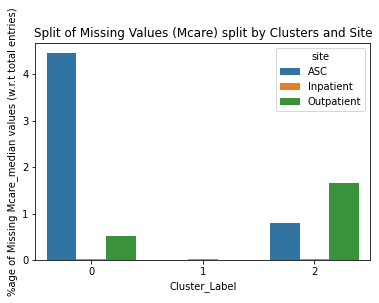

In [24]:
missing_mcare = filter_df[filter_df["mcare_pay_median"].isna()][["msa","clusters","site"]]
temp = pd.DataFrame({"msa":[0, 0, 0],
                    "clusters":[1, 2, 0],
                   "site":["Inpatient","Inpatient","Inpatient"]})
x = missing_mcare.append(temp)[["clusters","site"]].groupby(by = ["clusters","site"]).size().reset_index()
x[0] = (x[0]/data.shape[0])*100
fig = sns.barplot(data=x,x="clusters",y = 0,hue="site")
fig.set(xlabel ="Cluster_Label", ylabel = "%age of Missing Mcare_median values (w.r.t total entries)", title ='Split of Missing Values (Mcare) split by Clusters and Site')

In [25]:
 missing_mcare.append(temp)[["clusters","site"]].groupby(by = ["clusters","site"]).size().reset_index()
x[0] = (x[0]/total_mcare_missing)*100
x

,clusters,site,0
0,0,ASC,0.948092
1,0,Inpatient,0.005043
2,0,Outpatient,0.110947
3,1,Inpatient,0.005043
4,2,ASC,0.171463
5,2,Inpatient,0.005043
6,2,Outpatient,0.353013


[Text(0.5, 0, 'Cluster_Label'),
 Text(0, 0.5, '%age of Non Missing Mcare_median values (w.r.t total entries)'),
 Text(0.5, 1.0, 'Split of Non Missing Values (Mcare) split by Clusters and Site')]

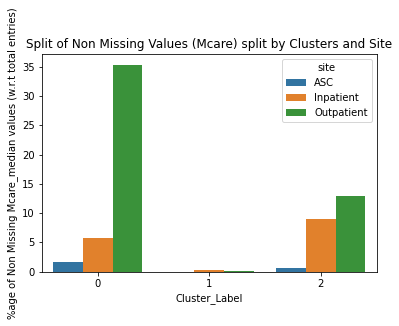

In [26]:
non_missing_mcare = filter_df[~filter_df["mcare_pay_median"].isna()][["msa","clusters","site"]]
x =non_missing_mcare[["clusters","site"]].groupby(by = ["clusters","site"]).size().reset_index()
x[0] = (x[0]/data.shape[0])*100
fig = sns.barplot(data=x,x="clusters",y = 0,hue="site")
fig.set(xlabel ="Cluster_Label", ylabel = "%age of Non Missing Mcare_median values (w.r.t total entries)", title ='Split of Non Missing Values (Mcare) split by Clusters and Site')

In [27]:
non_missing_mcare[["clusters","site"]].groupby(by = ["clusters","site"]).size().reset_index()

,clusters,site,0
0,0,ASC,67
1,0,Inpatient,245
2,0,Outpatient,1491
3,1,Inpatient,13
4,1,Outpatient,3
5,2,ASC,30
6,2,Inpatient,379
7,2,Outpatient,543


In [28]:
filter_df[(filter_df["msa_cluster"] == "0_26420.0")]["mcare_cluster_mean"].unique()[0]

5221.740770207848

### plotting these distributions using histogram plots and KDE plots (to look for multimodality), we also quantify this multimodality using hartigan's dip test and perform normality tests, t - tests (to check if mean of the distribution is same as the mean of the cluster it belongs to). 

In [29]:
uniq_msa_clust = filter_df["msa_cluster"].unique()
grid = mt.ceil(np.sqrt(len(uniq_msa_clust)))

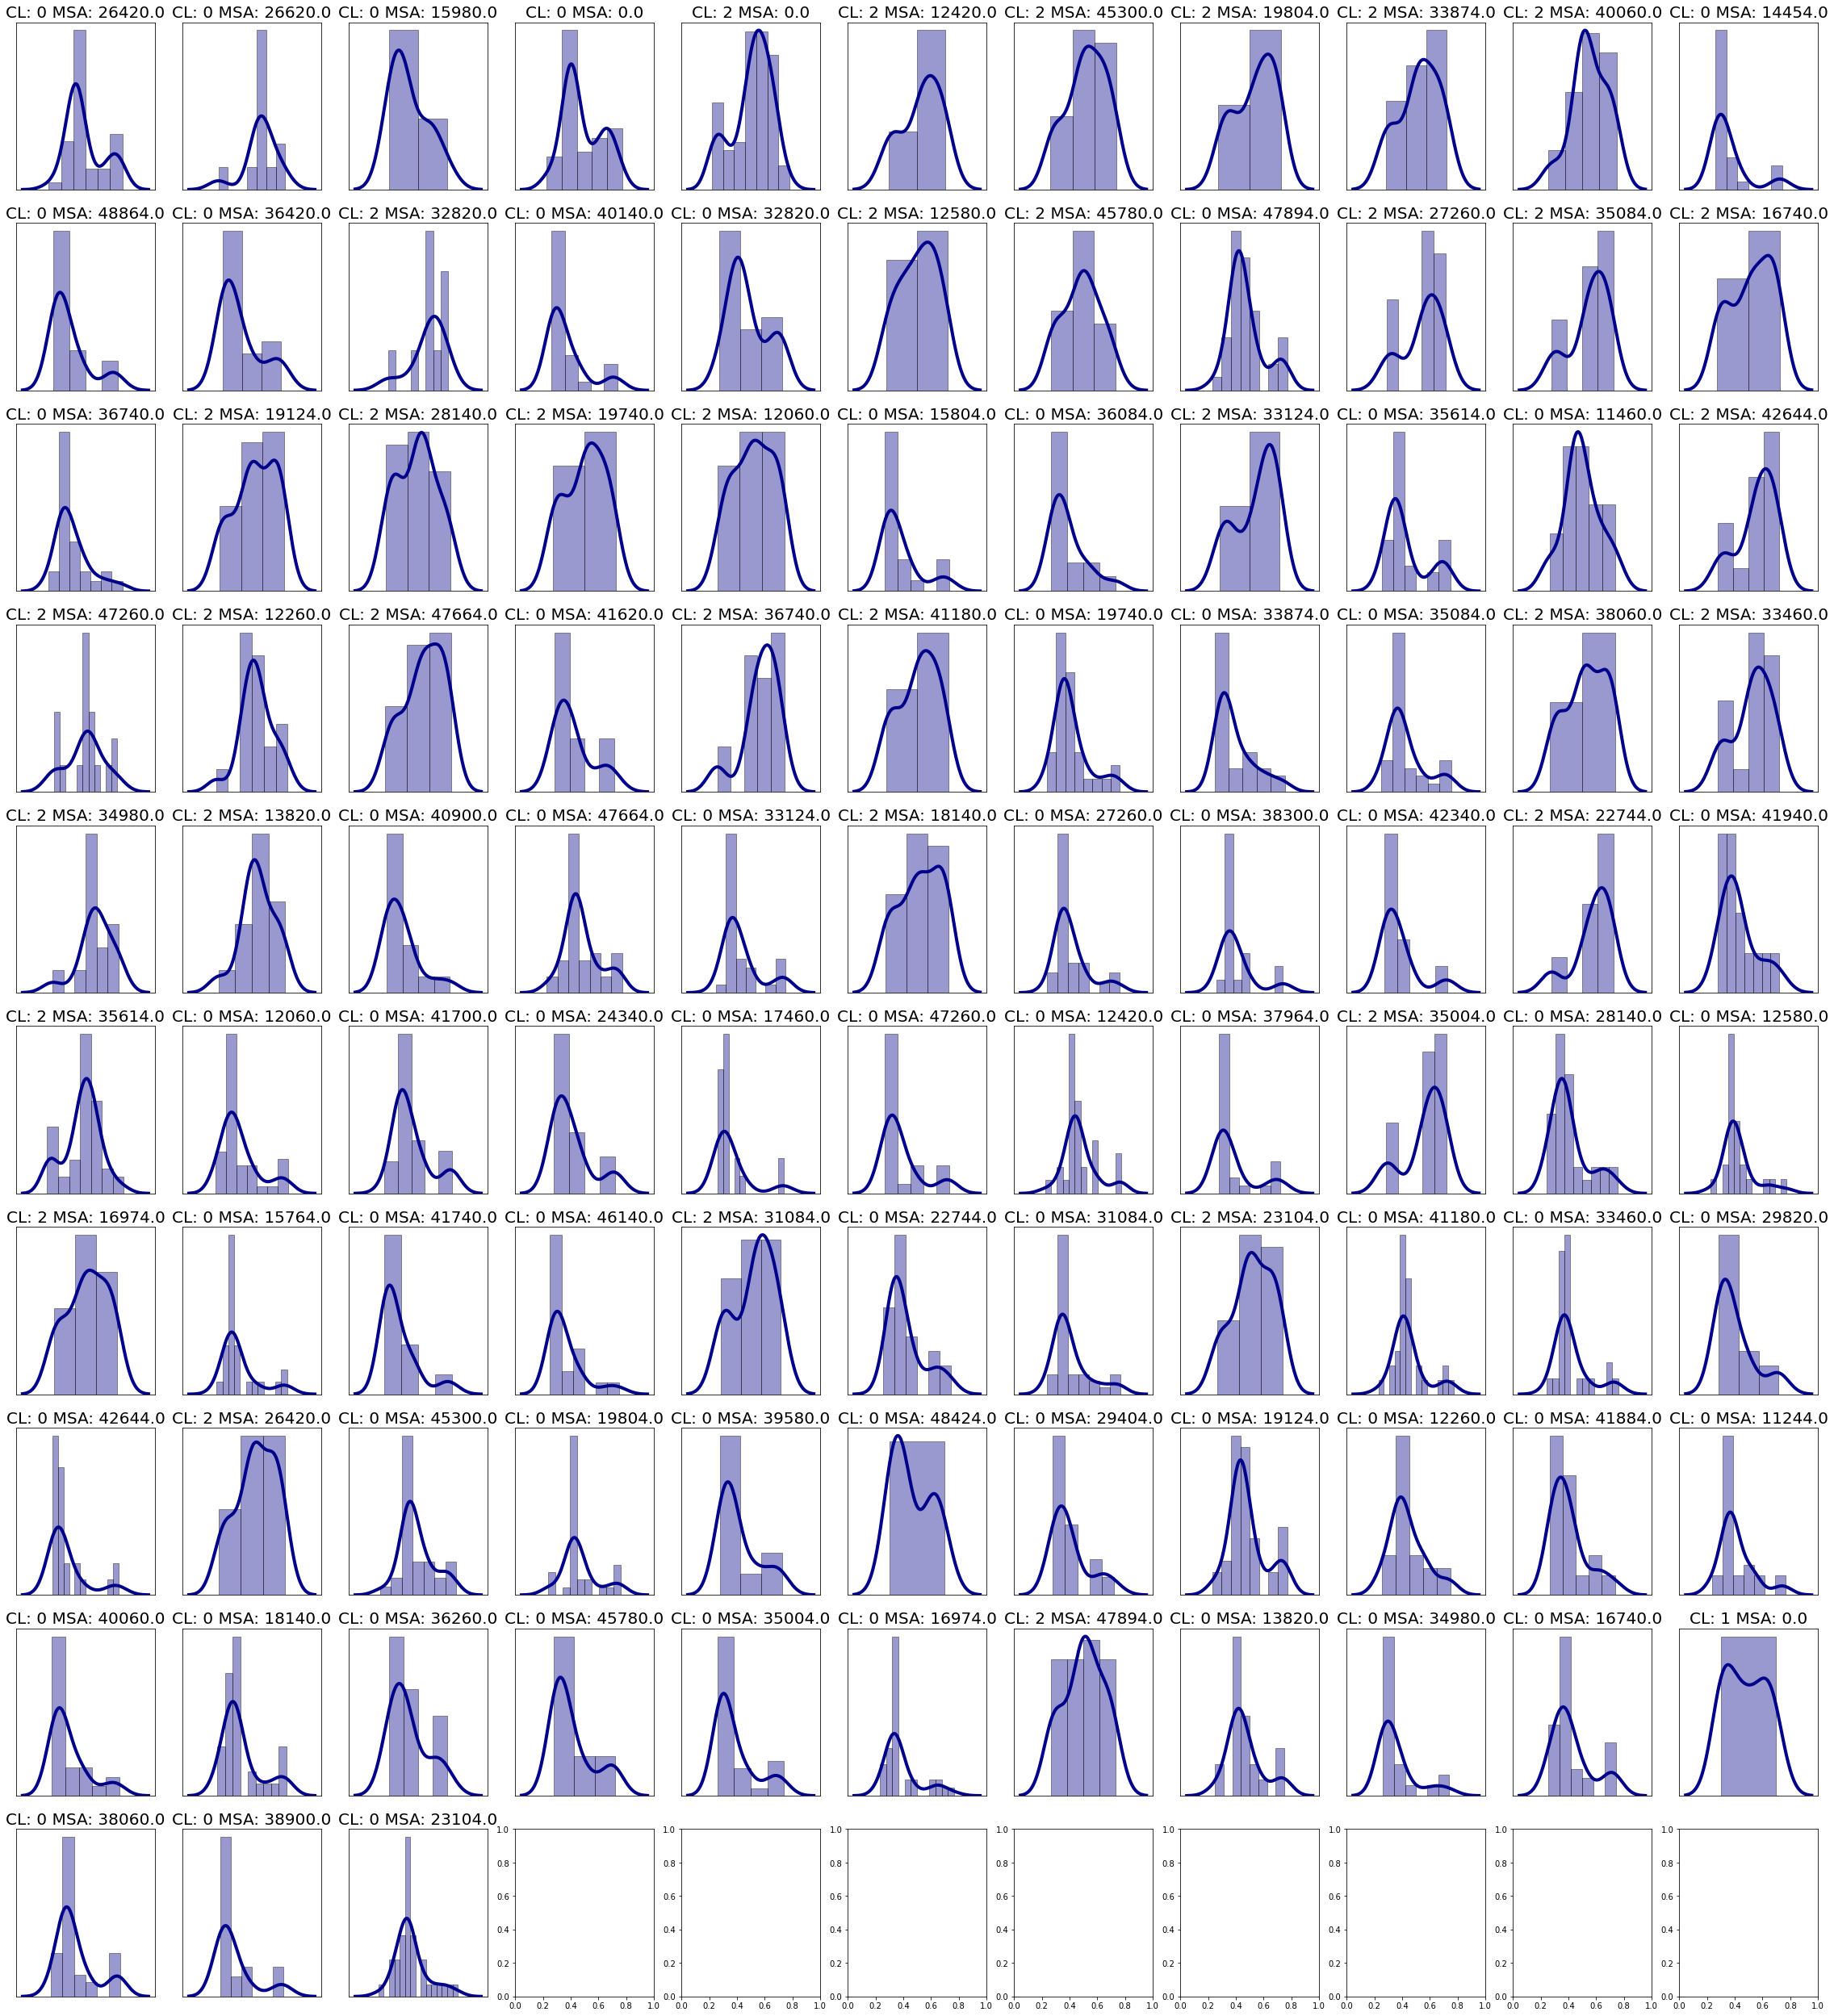

In [30]:
fig, axs = plt.subplots(grid-1, grid, figsize=(40,45))
normality_test = []
t_test_p = []
t_test_st = []
clusters = []
msas = []
interval_list = []
n_pts = []
missing_pts = []
means = []
sd_list = []
for i,x in enumerate(uniq_msa_clust):

    dt_pts = filter_df[(filter_df["msa_cluster"] == x)]["mcare_pay_median"]
    clusters.append(int(x.split("_")[0]))
    msas.append(float(x.split("_")[1]))
    k ,p = stats.normaltest(dt_pts,nan_policy="omit")
#     label.append(x)
    normality_test.append(p)
    n_pts.append(len(dt_pts[~np.isnan(dt_pts)]))
    missing_pts.append(len(dt_pts[np.isnan(dt_pts)]))
    gp_stats = dt_pts.describe()
    mu = gp_stats[1]
    std = gp_stats[2]
    means.append(mu)
    sd_list.append(std)
    cl_mean = filter_df[(filter_df["msa_cluster"] == x)]["mcare_cluster_mean"].unique()[0]
    t_test = stats.ttest_1samp(dt_pts, popmean=cl_mean,nan_policy='omit')
    t_test_p.append(t_test[1])
    t_test_st.append(t_test[0])
    Q1 = np.percentile(dt_pts[~np.isnan(dt_pts)], 25, interpolation = 'midpoint')
    Q3 = np.percentile(dt_pts[~np.isnan(dt_pts)], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    if len(dt_pts) == 0:
        opt_bins = 10
    else:
        bin_width = 2*IQR/np.cbrt(len(dt_pts))
        rng = max(dt_pts[~np.isnan(dt_pts)]) - min(dt_pts[~np.isnan(dt_pts)])
        opt_bins = int(rng/bin_width)
    sns.distplot(dt_pts, hist=True, kde=True, 
             bins=opt_bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                ax=axs[int(i/grid),i%grid])
    dt_pts = np.msort(dt_pts)
    intervals = UniDip(dt_pts[~np.isnan(dt_pts)]).run()
    interval_list.append(intervals)
    axs[int(i/grid),i%grid].get_yaxis().set_visible(False)
    axs[int(i/grid),i%grid].get_xaxis().set_visible(False)
    axs[int(i/grid),i%grid].set_title("CL: " + str(int(x.split("_")[0])) + " MSA: " + str(float(x.split("_")[1])),fontsize = 20)
# plt.savefig("density_plots.png")
#     axs[int(i/grid),i%grid].set_title(intervals[0][1])

### saving useful metrics from the above distributions and tests in a dataframe

In [31]:
output_df = pd.DataFrame(list(zip(clusters,msas, fdrcorrection(normality_test,alpha=0.1)[1],fdrcorrection(t_test_p,alpha=0.1)[1],t_test_st,interval_list,n_pts,missing_pts,means,sd_list)),columns=["Cluster_Label","MSA","Normality_p_value","T_test_p_value","T-Statistic","dip_test_interval","no_pts","no_missing_mcare","mean","SD"])
output_df["msa_cluster"] = output_df["Cluster_Label"].astype(str) + "_" + output_df["MSA"].astype(str)
# print("%age of MSAxCluster groups where we cannot reject the NULL hypothesis is (90% CI) :",100*len(output_df[output_df["Normality_p_value"] >= 0.1])/len(output_df))
# output_df.sort_values(by=["Normality_p_value"],ascending=False)
output_df

,Cluster_Label,MSA,Normality_p_value,T_test_p_value,T-Statistic,dip_test_interval,no_pts,no_missing_mcare,mean,SD,msa_cluster
0,0,26420.0,0.127812,0.788805,0.620920,"[(0, 44)]",45,3,5486.180995,2856.920569,0_26420.0
1,0,26620.0,0.013838,0.123862,-2.943756,"[(0, 11)]",12,3,3945.866667,1501.400623,0_26620.0
2,0,15980.0,0.422595,0.316869,-1.843431,"[(0, 12)]",13,3,4703.731538,1013.170067,0_15980.0
3,0,0.0,0.031388,0.303299,1.756479,"[(0, 72)]",73,9,5829.697603,2957.272034,0_0.0
4,2,0.0,0.080576,0.924204,0.177721,"[(0, 81)]",82,13,11668.956890,5658.711046,2_0.0
...,...,...,...,...,...,...,...,...,...,...,...
97,0,16740.0,0.046467,0.648921,-0.947087,"[(0, 36)]",37,6,4831.688772,2505.147573,0_16740.0
98,1,0.0,0.062180,0.181929,-2.349800,"[(0, 15)]",16,0,20374.278437,10163.846384,1_0.0
99,0,38060.0,0.013838,0.924204,0.135872,"[(0, 38)]",39,3,5275.723344,2481.169257,0_38060.0
100,0,38900.0,0.004533,0.631821,1.061741,"[(0, 23)]",24,3,5798.572292,2661.559017,0_38900.0


In [32]:
output_df[(output_df["T_test_p_value"] > 0.5) & (output_df["no_pts"] > 25)]

,Cluster_Label,MSA,Normality_p_value,T_test_p_value,T-Statistic,dip_test_interval,no_pts,no_missing_mcare,mean,SD,msa_cluster
0,0,26420.0,0.127812,0.788805,0.620920,"[(0, 44)]",45,3,5486.180995,2856.920569,0_26420.0
4,2,0.0,0.080576,0.924204,0.177721,"[(0, 81)]",82,13,11668.956890,5658.711046,2_0.0
6,2,45300.0,0.389993,0.790155,-0.568563,"[(0, 30)]",31,1,11054.320806,4931.385112,2_45300.0
7,2,19804.0,0.116350,0.853197,-0.457147,"[(0, 25)]",26,3,11047.795192,5689.699707,2_19804.0
18,0,47894.0,0.047050,0.990200,-0.012364,"[(0, 38)]",39,3,5216.321102,2737.355990,0_47894.0
21,2,16740.0,0.025541,0.788805,-0.618736,"[(0, 33)]",34,2,10975.952136,5484.254439,2_16740.0
22,0,36740.0,0.012674,0.886566,-0.377989,"[(0, 28)]",29,3,5060.612045,2295.584796,0_36740.0
23,2,19124.0,0.087106,0.924204,-0.244749,"[(0, 36)]",37,2,11345.310382,5283.491647,2_19124.0
35,2,47664.0,0.221029,0.942695,0.084182,"[(0, 31)]",32,7,11641.294203,5603.976773,2_47664.0
39,0,19740.0,0.008259,0.788805,-0.692952,"[(0, 31)]",32,6,4957.776087,2154.852929,0_19740.0


### 

[Text(0.5, 0, 'Distribution_Mean'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Histogram Showing means of the MSA X Cluster Distributions (Split By Cluster_Label)')]

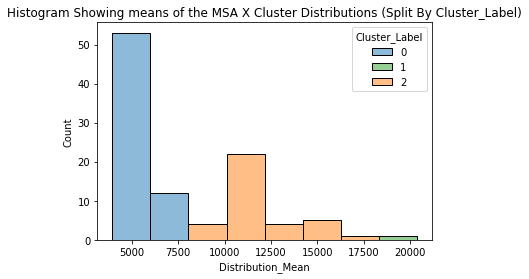

In [33]:
fig = sns.histplot(data=output_df, x="mean", hue="Cluster_Label",palette = ['tab:blue', 'tab:green', 'tab:orange'])
fig.set(xlabel ="Distribution_Mean", ylabel = "Count", title ='Histogram Showing means of the MSA X Cluster Distributions (Split By Cluster_Label)')

[Text(0.5, 0, 'P-Value from Normality Tests'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Histogram showing distribution of P values split by cluster labels')]

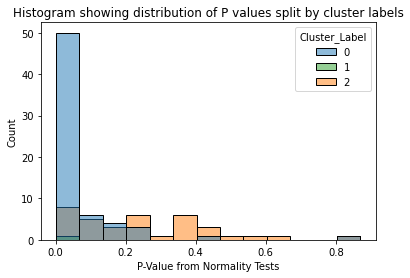

In [34]:
fig = sns.histplot(data=output_df, x="Normality_p_value", hue="Cluster_Label",palette = ['tab:blue', 'tab:green', 'tab:orange'])
fig.set(xlabel ="P-Value from Normality Tests", ylabel = "Count", title ='Histogram showing distribution of P values split by cluster labels')

### Checking how many missing values do we have for Mcare median where we cannot reject the NULL hyp. in the normality test (i.e. the distributions are normal)

In [35]:
output_df[output_df["Normality_p_value"] > 0.1]["no_missing_mcare"].sum()

94

### To confirm if these distrbutions are actually normal, we see their QQ plots

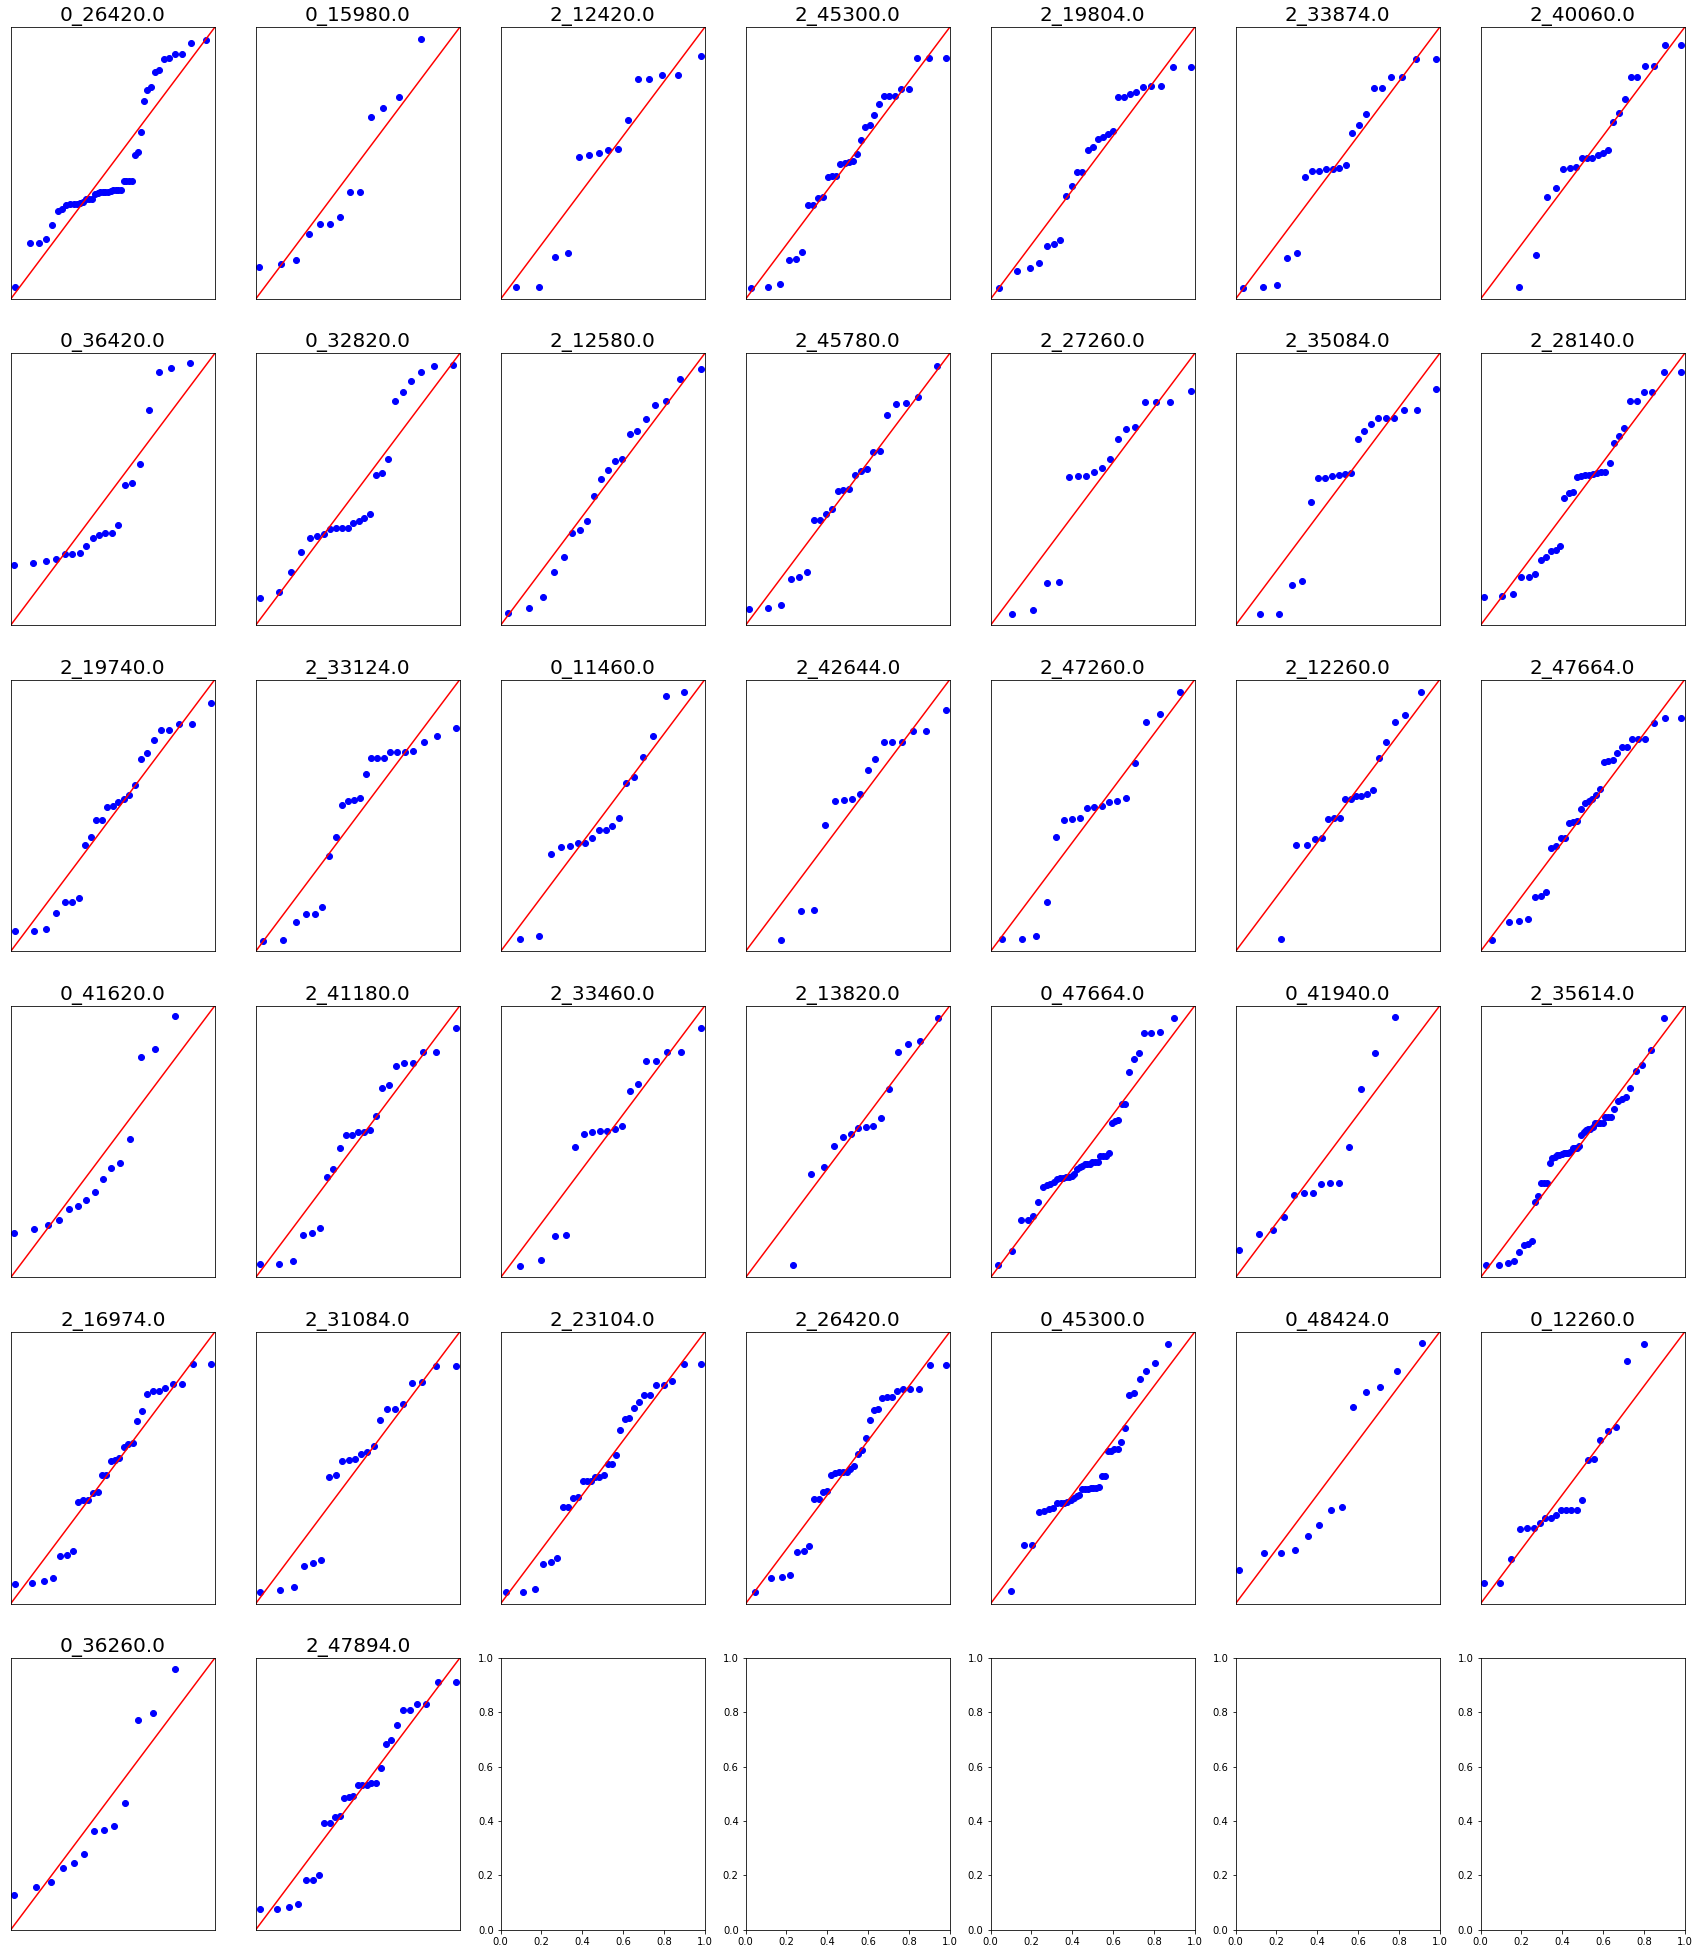

In [36]:
normality_check = filter_df.merge(output_df[output_df["Normality_p_value"] > 0.1], on = ["msa_cluster"],how = 'inner')
uniq_msa_clust_norm = normality_check["msa_cluster"].unique()
grid = mt.ceil(np.sqrt(len(uniq_msa_clust_norm)))
fig, axs = plt.subplots(grid-1, grid, figsize=(30,35))
for i,x in enumerate(uniq_msa_clust_norm):
    dt_pts = normality_check[(normality_check["msa_cluster"] == x)]["mcare_pay_median"]
    gp_stats = dt_pts.describe()
    mu = gp_stats[1]
    std = gp_stats[2]
    rmv_outliers = dt_pts[(dt_pts > mu - 3*std) & (dt_pts < mu + 3*std)].values
    sm.qqplot(rmv_outliers,dist=norm(mu,std), line ='45',ax=axs[int(i/grid),i%grid])
    axs[int(i/grid),i%grid].get_yaxis().set_visible(False)
    axs[int(i/grid),i%grid].get_xaxis().set_visible(False)
    axs[int(i/grid),i%grid].set_title(str(x),fontsize = 20)

### trying to remove multimodality by splitting into ASC, inpatient and outpatient (testing this out for one of the examples)

<AxesSubplot:xlabel='mcare_pay_median', ylabel='Density'>

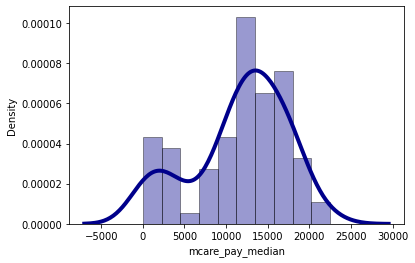

In [37]:
multi_mod_test = filter_df[filter_df["msa_cluster"] == uniq_msa_clust[4]]
sns.distplot(multi_mod_test["mcare_pay_median"], hist=True, kde=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

[None, None, None, None]

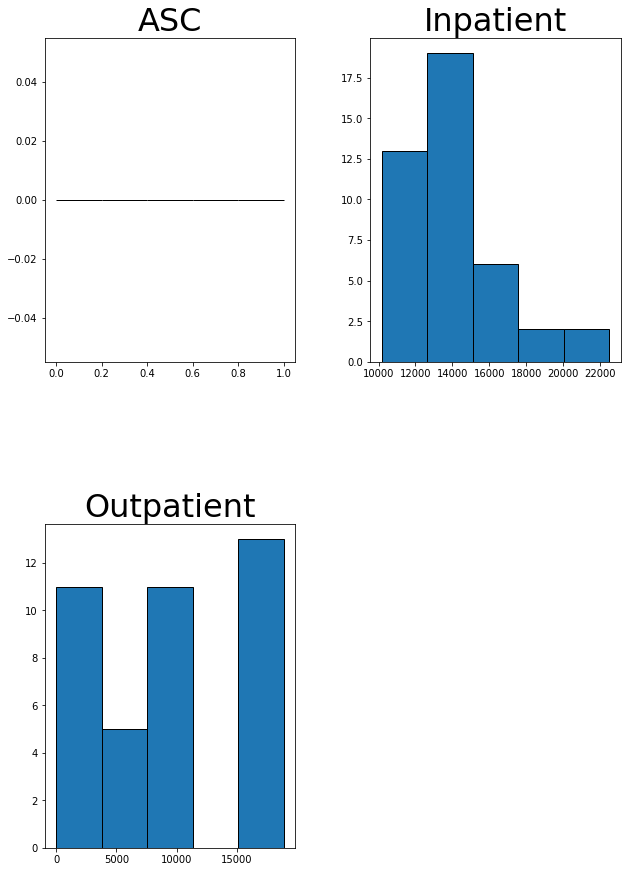

In [38]:
fig = plt.figure(figsize = (10,15))
ax = fig.gca()
plt.tight_layout()
fig = (multi_mod_test["mcare_pay_median"]).hist(by = multi_mod_test["site"] ,bins = 5, ax = ax,ec="k",rot = 0)
[x.title.set_size(32) for x in fig.ravel()]
# plt.savefig("diff_gp_hist.png",dpi = 100)

### looking at distributions for mcare_pay_median for outpatient site only

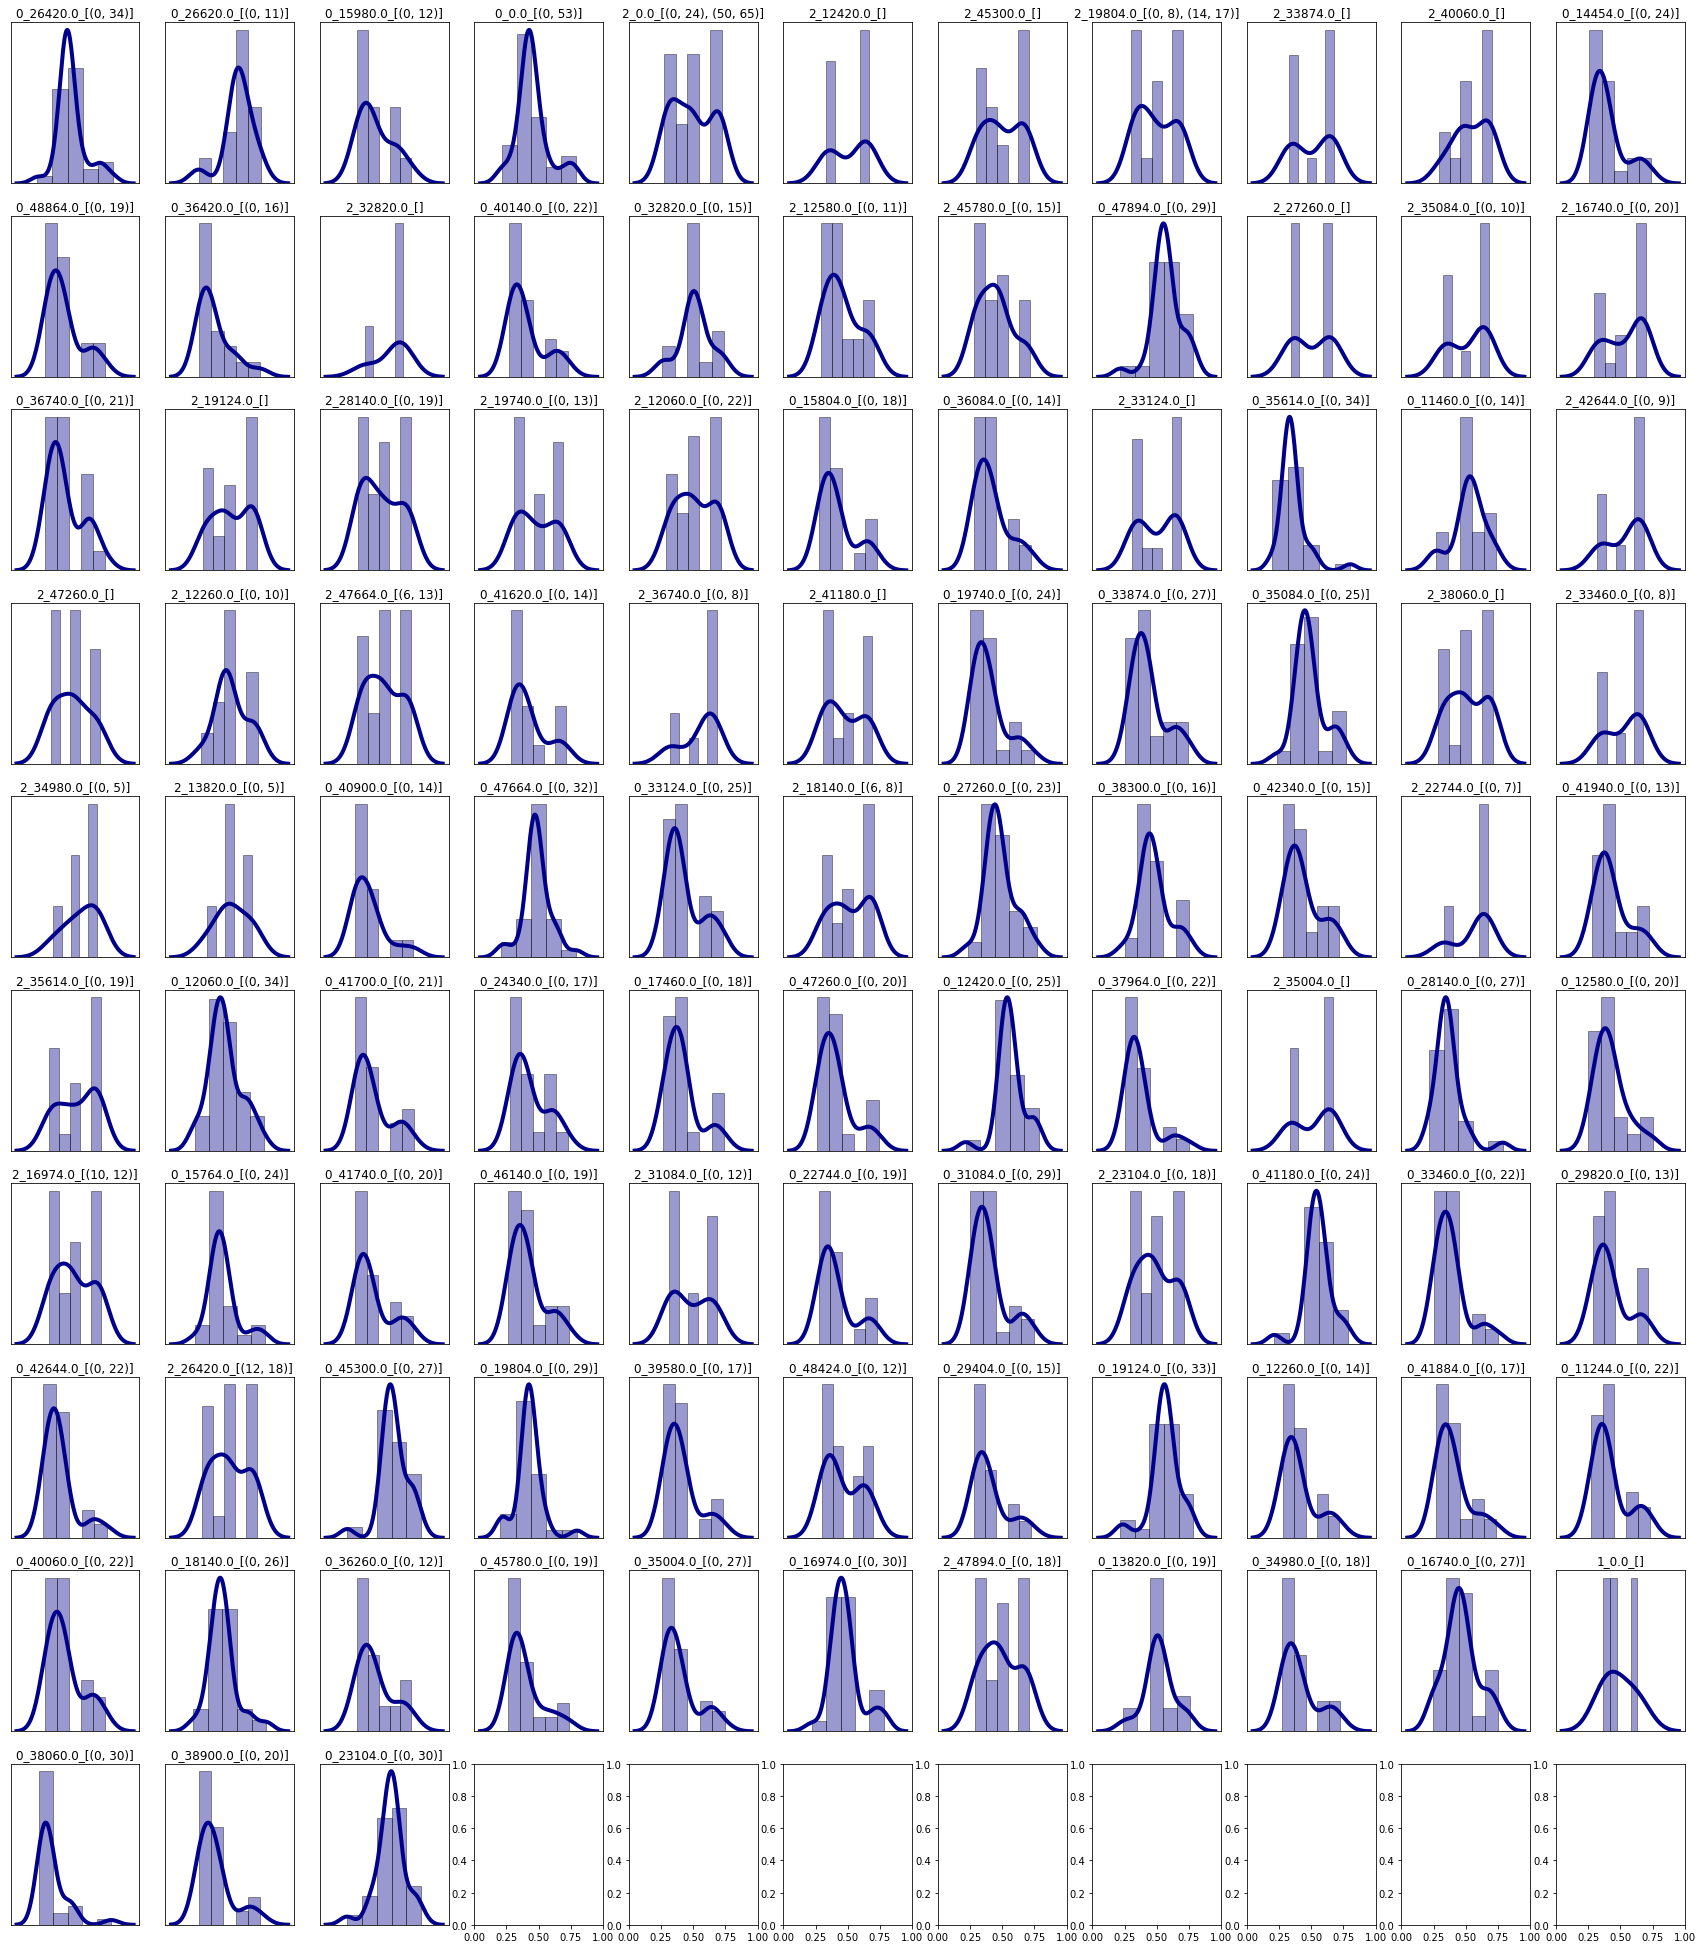

In [39]:
grid = mt.ceil(np.sqrt(len(uniq_msa_clust)))
fig, axs = plt.subplots(grid-1, grid, figsize=(30,35))
t_test_p = []
t_test_st = []
means = []
sd_list = []
clusters = []
msas = []
n_pts = []
missing_pts = []
for i,x in enumerate(uniq_msa_clust):
    dt_pts = filter_df[(filter_df["msa_cluster"] == x) & (filter_df["site"] == "Outpatient")]["mcare_pay_median"]
#     Q1 = np.percentile(dt_pts[~np.isnan(dt_pts)], 25, interpolation = 'midpoint')
#     Q3 = np.percentile(dt_pts[~np.isnan(dt_pts)], 75, interpolation = 'midpoint')
#     IQR = Q3 - Q1

#     if (opt_bins == 0) or IQR == 0:
#         opt_bins = 10
#     else:
#         bin_width = 2*IQR/np.cbrt(len(dt_pts))
#         rng = max(dt_pts[~np.isnan(dt_pts)]) - min(dt_pts[~np.isnan(dt_pts)])
#         opt_bins = int(rng/bin_width)
    
#     if opt_bins == 0:
#         opt_bins = 5
    sns.distplot(dt_pts, hist=True, kde=True, 
             bins=5, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                ax=axs[int(i/grid),i%grid])
    t_test = stats.ttest_1samp(dt_pts, popmean=np.mean(dt_pts),nan_policy='omit')
    t_test_p.append(t_test[1])
    t_test_st.append(t_test[0])
    clusters.append(int(x.split("_")[0]))
    msas.append(float(x.split("_")[1]))
    n_pts.append(len(dt_pts[~np.isnan(dt_pts)]))
    missing_pts.append(len(dt_pts[np.isnan(dt_pts)]))
    gp_stats = dt_pts.describe()
    mu = gp_stats[1]
    std = gp_stats[2]
    means.append(mu)
    sd_list.append(std)
    dt_pts = np.msort(dt_pts)
    intervals = UniDip(dt_pts[~np.isnan(dt_pts)]).run()
    axs[int(i/grid),i%grid].get_yaxis().set_visible(False)
    axs[int(i/grid),i%grid].get_xaxis().set_visible(False)
    axs[int(i/grid),i%grid].set_title(str(x) + "_" +str(intervals))
# plt.savefig("density_plots.png")
#     axs[int(i/grid),i%grid].set_title(intervals[0][1])

In [40]:
output_df = pd.DataFrame(list(zip(clusters,msas,t_test_p,t_test_st,n_pts,missing_pts,means,sd_list)),columns=["Cluster_Label","MSA","T_test_p_value","T-Statistic","no_pts","no_missing_mcare","mean","SD"])
output_df["msa_cluster"] = output_df["Cluster_Label"].astype(str) + "_" + output_df["MSA"].astype(str)
output_df

,Cluster_Label,MSA,T_test_p_value,T-Statistic,no_pts,no_missing_mcare,mean,SD,msa_cluster
0,0,26420.0,1.0,0.000000e+00,35,0,4766.000571,1985.854460,0_26420.0
1,0,26620.0,1.0,0.000000e+00,12,0,3945.866667,1501.400623,0_26620.0
2,0,15980.0,1.0,-6.473207e-15,13,0,4703.731538,1013.170067,0_15980.0
3,0,0.0,1.0,3.070660e-15,54,0,4541.429444,2176.533544,0_0.0
4,2,0.0,1.0,0.000000e+00,40,1,9116.143500,6812.260432,2_0.0
...,...,...,...,...,...,...,...,...,...
97,0,16740.0,1.0,3.995134e-15,28,3,4054.546607,1204.613751,0_16740.0
98,1,0.0,1.0,0.000000e+00,3,0,8983.376667,1047.786119,1_0.0
99,0,38060.0,1.0,-3.481811e-15,31,0,4722.290000,1454.372916,0_38060.0
100,0,38900.0,1.0,3.743855e-15,21,0,4892.516429,1113.245254,0_38900.0


In [41]:
output_df[(output_df["no_missing_mcare"] != 0)]

,Cluster_Label,MSA,T_test_p_value,T-Statistic,no_pts,no_missing_mcare,mean,SD,msa_cluster
4,2,0.0,1.0,0.000000e+00,40,1,9116.143500,6812.260432,2_0.0
5,2,12420.0,1.0,0.000000e+00,9,3,10928.281111,7253.122933,2_12420.0
6,2,45300.0,1.0,0.000000e+00,20,1,10380.367500,5963.467812,2_45300.0
7,2,19804.0,1.0,0.000000e+00,17,3,9505.459706,6424.323965,2_19804.0
8,2,33874.0,1.0,-8.215408e-16,12,1,11622.231667,7669.934125,2_33874.0
9,2,40060.0,1.0,-1.244729e-15,13,3,11742.670769,5268.985845,2_40060.0
13,2,32820.0,1.0,0.000000e+00,4,3,12758.817500,7142.368857,2_32820.0
16,2,12580.0,1.0,0.000000e+00,12,3,12655.144583,6949.849871,2_12580.0
20,2,35084.0,1.0,0.000000e+00,11,2,13783.368182,8153.903097,2_35084.0
21,2,16740.0,1.0,-1.348174e-15,21,1,11587.624524,6182.923986,2_16740.0


In [42]:
output_df[(output_df["no_missing_mcare"] != 0)]["no_missing_mcare"].sum()

92

### looking at distributions of mcare_pay_median at a cluster X site level

In [43]:
cluster_site_df = data
cluster_site_df["cluster_site"] = [str(i) + j + z for i,j,z in zip(list(data["clusters"].values),["_"]*data.shape[0],data["site"].values)]

In [44]:
cluster_site_df

,id,msa,year,site,group,priv_count,priv_pay_mean,priv_pay_median,priv_pay_iqr,mcare_count,mcare_los,mcare_pay_mean,mcare_pay_median,mcare_pay_sd,CBSA_NAME,State,lon,lat,clusters,cluster_site
62502,26420.0_2018_Inpatient_breast reconstruction,26420.0,2018,Inpatient,breast reconstruction,51.0,47327.576470,21408.00,23351.7150,81.0,3.54321,14027.076170,10395.16,12242.654150,"Houston-The Woodlands-Sugar Land, TX",Texas,-95.622552,29.598443,0,0_Inpatient
62503,28660.0_2018_Outpatient_breast reconstruction,28660.0,2018,Outpatient,breast reconstruction,51.0,8048.568431,9495.08,6468.6300,72.0,0.00000,4325.565833,3609.09,2791.209179,"Killeen-Temple, TX",Texas,-97.698227,31.124151,0,0_Outpatient
62504,37340.0_2018_Outpatient_breast reconstruction,37340.0,2018,Outpatient,breast reconstruction,51.0,34211.443140,17213.58,24034.8250,68.0,0.00000,5490.479412,4130.65,3880.597914,"Palm Bay-Melbourne-Titusville, FL",Florida,-80.721442,28.263933,0,0_Outpatient
62505,26620.0_2019_Outpatient_breast reconstruction,26620.0,2019,Outpatient,breast reconstruction,51.0,6233.098627,5643.14,3529.6100,70.0,0.00000,5081.383000,3947.27,2657.779225,"Huntsville, AL",Alabama,-86.586104,34.730369,0,0_Outpatient
62506,15980.0_2020_Outpatient_breast reconstruction,15980.0,2020,Outpatient,breast reconstruction,51.0,21964.297060,11824.70,17573.6400,71.0,0.00000,6320.088451,4640.27,4468.429407,"Cape Coral-Fort Myers, FL",Florida,-81.872308,26.640628,0,0_Outpatient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66716,0.0_2018_Outpatient_hysterect,0.0,2018,Outpatient,hysterect,6335.0,14677.391800,12040.63,11607.0600,2732.0,0.00000,5067.601204,5491.66,1787.807187,NaN,NaN,NaN,NaN,0,0_Outpatient
66717,nan_2018_Outpatient_rtc_slap_bank,NaN,2018,Outpatient,rtc_slap_bank,6910.0,14537.588820,12213.92,10731.0675,10765.0,0.00000,5460.250379,4843.63,4561.683011,NaN,NaN,NaN,NaN,0,0_Outpatient
66718,0.0_2020_Outpatient_rtc_slap_bank,0.0,2020,Outpatient,rtc_slap_bank,7071.0,14769.380650,12657.14,12031.9000,17493.0,0.00000,4579.359115,4554.80,1716.745885,NaN,NaN,NaN,NaN,0,0_Outpatient
66719,0.0_2019_Outpatient_rtc_slap_bank,0.0,2019,Outpatient,rtc_slap_bank,8154.0,14388.208800,11857.93,11813.4150,20552.0,0.00000,4243.786995,4259.62,1626.198810,NaN,NaN,NaN,NaN,0,0_Outpatient


In [45]:
uniq_cluster_site = cluster_site_df["cluster_site"].unique()
grid = mt.ceil(np.sqrt(len(uniq_cluster_site)))

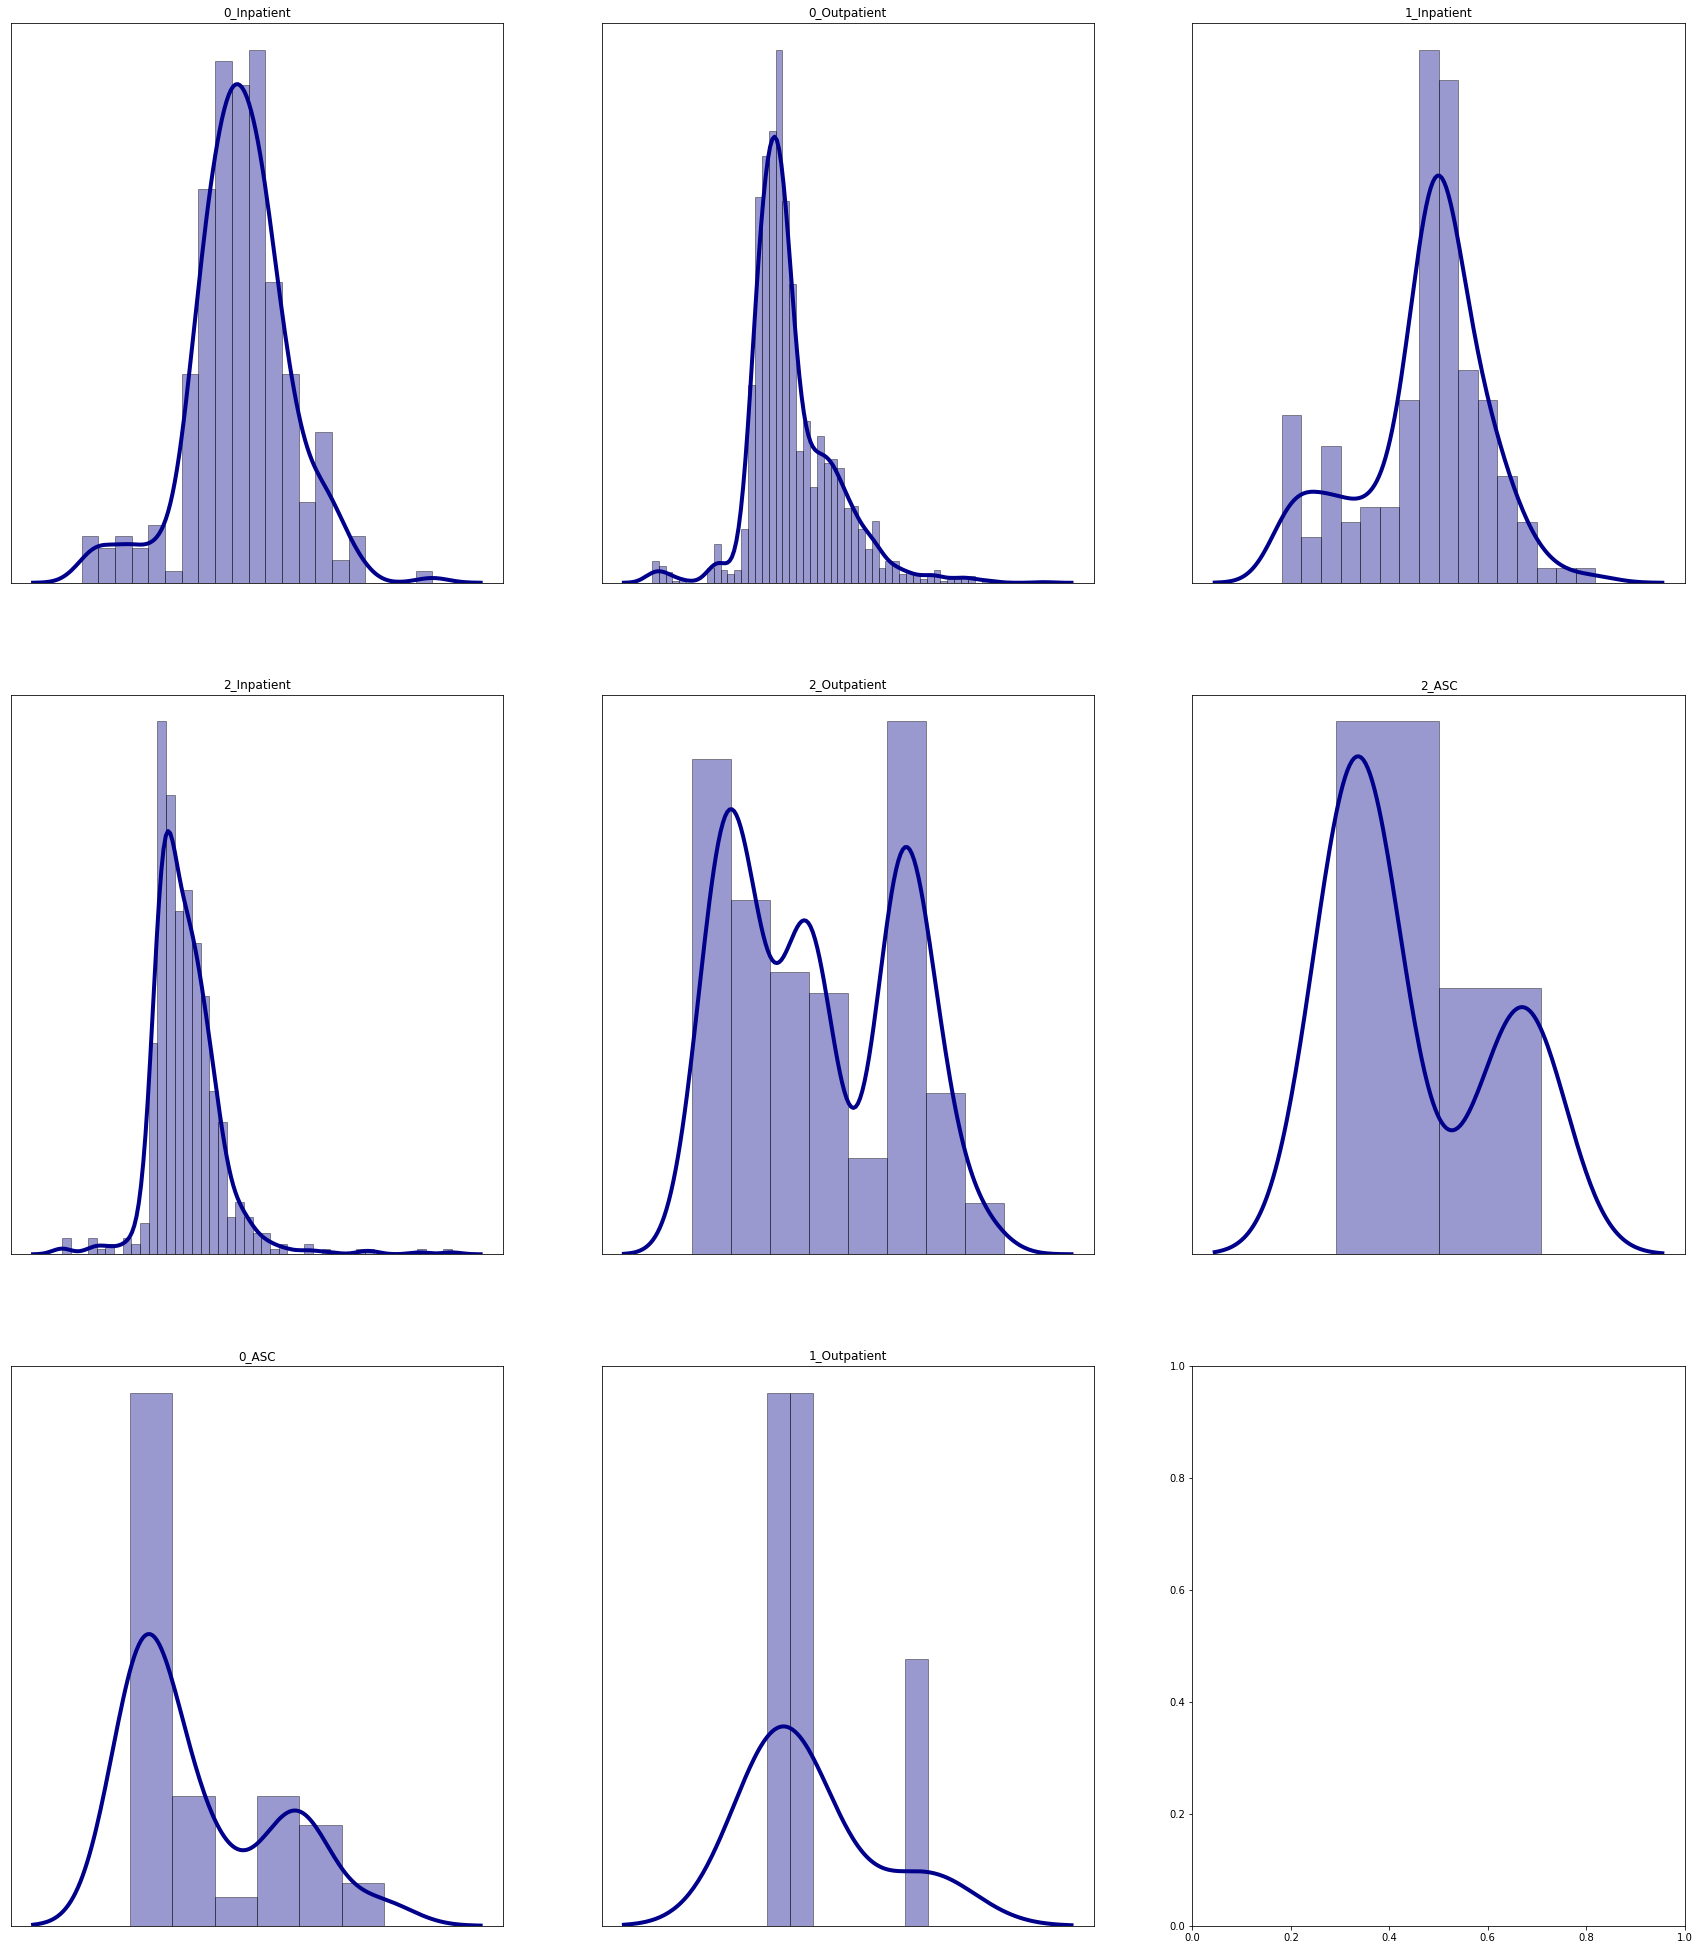

In [46]:
fig, axs = plt.subplots(grid, grid, figsize=(30,35))
n_pts = []
missing_pts = []
means = []
sd_list = []
labels = []
for i,x in enumerate(uniq_cluster_site):

    dt_pts = cluster_site_df[(cluster_site_df["cluster_site"] == x)]["mcare_pay_median"]
    Q1 = np.percentile(dt_pts[~np.isnan(dt_pts)], 25, interpolation = 'midpoint')
    Q3 = np.percentile(dt_pts[~np.isnan(dt_pts)], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    if len(dt_pts) == 0:
        opt_bins = 10
    else:
        bin_width = 2*IQR/np.cbrt(len(dt_pts))
        rng = max(dt_pts[~np.isnan(dt_pts)]) - min(dt_pts[~np.isnan(dt_pts)])
        opt_bins = int(rng/bin_width)
        
    n_pts.append(len(dt_pts[~np.isnan(dt_pts)]))
    missing_pts.append(len(dt_pts[np.isnan(dt_pts)]))
    gp_stats = dt_pts.describe()
    mu = gp_stats[1]
    std = gp_stats[2]
    means.append(mu)
    sd_list.append(std)
    labels.append(x)
    sns.distplot(dt_pts, hist=True, kde=True, 
             bins=opt_bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
                ax=axs[int(i/grid),i%grid])
#     dt_pts = np.msort(dt_pts)
#     intervals = UniDip(dt_pts[~np.isnan(dt_pts)]).run()
#     interval_list.append(intervals)
    axs[int(i/grid),i%grid].get_yaxis().set_visible(False)
    axs[int(i/grid),i%grid].get_xaxis().set_visible(False)
    axs[int(i/grid),i%grid].set_title(str(x))
# plt.savefig("density_plots.png")
#     axs[int(i/grid),i%grid].set_title(intervals[0][1])

In [47]:
output_df = pd.DataFrame(list(zip(labels,n_pts,missing_pts,means,sd_list)),columns=["index","no_pts","no_missing_mcare","mean","SD"])
# output_df["msa_cluster"] = output_df["Cluster_Label"].astype(str) + "_" + output_df["MSA"].astype(str)
# print("%age of MSAxCluster groups where we cannot reject the NULL hypothesis is (90% CI) :",100*len(output_df[output_df["Normality_p_value"] >= 0.1])/len(output_df))
# output_df.sort_values(by=["Normality_p_value"],ascending=False)
output_df

,index,no_pts,no_missing_mcare,mean,SD
0,0_Inpatient,277,0,10171.440957,2169.787843
1,0_Outpatient,1975,38,4629.089180,1410.055609
2,1_Inpatient,157,0,26819.030096,8108.833445
3,2_Inpatient,588,1,13401.810723,3762.698828
4,2_Outpatient,650,77,10197.057185,6684.118193
5,2_ASC,30,47,4902.140878,2391.621123
6,0_ASC,67,307,2228.008524,401.101239
7,1_Outpatient,5,0,11461.455000,5021.924998


[Text(0.5, 0, 'Mcare_pay_median'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Cluster 0')]

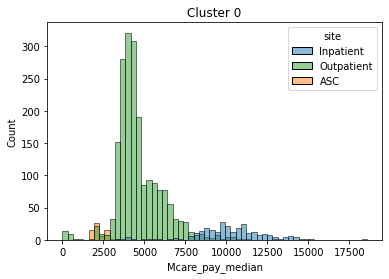

In [48]:
fig = sns.histplot(data=cluster_site_df[cluster_site_df["clusters"] == 0], x="mcare_pay_median", hue="site",palette = ['tab:blue', 'tab:green', 'tab:orange'])
fig.set(xlabel ="Mcare_pay_median", ylabel = "Count", title ='Cluster 0')

[Text(0.5, 0, 'Mcare_pay_median'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Cluster 1')]

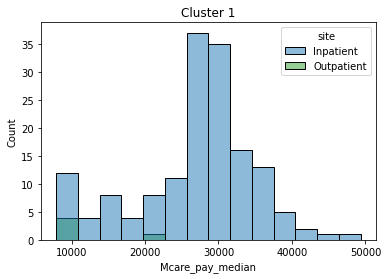

In [49]:
fig = sns.histplot(data=cluster_site_df[cluster_site_df["clusters"] == 1], x="mcare_pay_median", hue="site",palette = ['tab:blue', 'tab:green'])
fig.set(xlabel ="Mcare_pay_median", ylabel = "Count", title ='Cluster 1')

[Text(0.5, 0, 'Mcare_pay_median'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Cluster 2')]

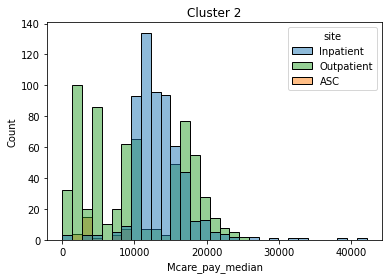

In [50]:
fig = sns.histplot(data=cluster_site_df[cluster_site_df["clusters"] == 2], x="mcare_pay_median", hue="site",palette = ['tab:blue', 'tab:green', 'tab:orange'])
fig.set(xlabel ="Mcare_pay_median", ylabel = "Count", title ='Cluster 2')

### checking for normality in the outpatient category in cluster 0

[Text(0.5, 0, 'Mcare_pay_median'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Cluster 0')]

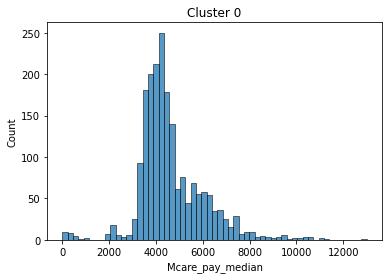

In [51]:
fig = sns.histplot(data=cluster_site_df[(cluster_site_df["clusters"] == 0) & (cluster_site_df["site"] == "Outpatient")], x="mcare_pay_median",palette = ['tab:blue', 'tab:green', 'tab:orange'])
fig.set(xlabel ="Mcare_pay_median", ylabel = "Count", title ='Cluster 0')

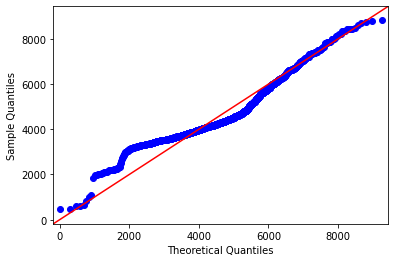

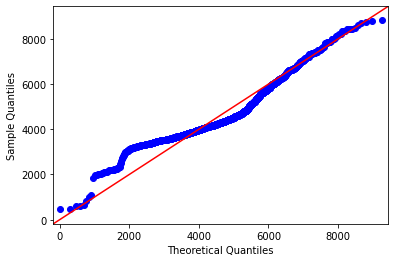

In [52]:
out_0 = cluster_site_df[(cluster_site_df["clusters"] == 0) & (cluster_site_df["site"] == "Outpatient")]["mcare_pay_median"]
gp_stats = out_0.describe()
mu = gp_stats[1]
std = gp_stats[2]
rmv_outliers = out_0[(out_0 > mu - 3*std) & (out_0 < mu + 3*std)].values
sm.qqplot(rmv_outliers,dist=norm(mu,std), line ='45')